In [7]:
path_sample = '/content/drive/My Drive/Colab Notebooks/PG/data/test/male-welfare.wav' #input("WAV path: ")
path_templates = '/content/drive/My Drive/Colab Notebooks/PG/data/templates.json' #input("Templates path: ")

use_microphone = True #True if input("Use microphone (yes, no): ") == 'yes' else False

ms_units = True #True if input("Use milliseconds as measurement units (yes, no): ") == 'yes' else False

noise_len = 150 #int(input("Noise length: "))
window_len = 45 #int(input("Window length: "))
hop_size = 13 #int(input("Hop size: "))

p = 20 #int(input("Endpointing P: "))
q = 5 #int(input("Endpointing Q: "))

coef_fun = 'lpcc' #input("Coefficients (lpcc, mfcc): ")

lpcc_len = 13 #int(input("LPCC length: "))

window_fun = 'hanning' #input("Windowing function (hanning, hamming, none): ")
filter_num = 10 #int(input("Total filters: "))
mfcc_len = 13 #int(input("MFCC length: "))
mfcc_delta = False #True if input("Use MFCC delta parameters (yes, no): ") == 'yes' else False
mfcc_tau = 3 #int(input("MFCC tau: "))

In [2]:
!pip install ffmpeg-python

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/PG/data/record/’: File exists


In [3]:
import io
import sys
import json
import ffmpeg
import numpy as np
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
from sys import exit
from base64 import b64decode
from IPython.display import Audio
from google.colab.output import eval_js
from IPython.display import HTML, Audio

In [14]:
def record_wav():
    JS = """<script>
        var recordButton = document.createElement("button");
        var reader, recorder, gumStream, base64data;

        var handleSuccess = function(stream) {
            gumStream = stream;
            var options = {mimeType:'audio/webm;codecs=opus'};
            recorder = new MediaRecorder(stream);
            recorder.ondataavailable = function(e) {
                var url = URL.createObjectURL(e.data);
                reader = new FileReader();
                reader.readAsDataURL(e.data);
                reader.onloadend = () => base64data = reader.result;
            };
            recorder.start();
        };

        var data = new Promise(resolve => {
            recordButton.onclick = () => {
                if(recorder && recorder.state == "recording") {
                    recorder.stop();
                    gumStream.getAudioTracks()[0].stop();
                }
                new Promise(resolve => setTimeout(resolve, 2000)).then(() => {
                    resolve(base64data.toString())
                });
            }
        });

        document.body.appendChild(recordButton);
        recordButton.innerText = "Stop recording";
        navigator.mediaDevices.getUserMedia({audio:true}).then(handleSuccess);
        </script>"""

    display(HTML(JS))
    data = eval_js('data')
    binary = b64decode(data.split(',')[1])

    process = (ffmpeg.input('pipe:0')
            .output('pipe:1', format='wav')
            .run_async(pipe_stdin=True,
                       pipe_stdout=True,
                       pipe_stderr=True,
                       quiet=True,
                       overwrite_output=True))

    output, _ = process.communicate(input=binary)

    q, b = len(output) - 8, []

    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    rate, data = wf.read(io.BytesIO(output[:4] + bytes(b) + output[8:]))

    return rate, data


def load_wav(path):
    global ms_units, noise_len, window_len, hop_size

    rate, data = record_wav() if use_microphone else wf.read(path)

    if np.array(data).ndim > 1:
        data = data[:, 0]

    if ms_units:
        noise_len = ms_to_samples(noise_len, rate)
        window_len = ms_to_samples(window_len, rate)
        hop_size = ms_to_samples(hop_size, rate)
        ms_units = False

    return data, rate


def play_wav(data, rate):
    display(Audio(data, rate=rate))


def load_templates(path):
    try:
        with open(path, 'r') as fd:
            return json.load(fd)
    except FileNotFoundError:
        return []


def save_templates(path, templates):
    with open(path, 'w') as fd:
        json.dump(templates, fd, indent=4)


def ms_to_samples(value, rate):
    return rate * value // 1000


def create_scaffolds(windows, curr, sub, length):
    i, lmt = 0, len(windows)
    
    if windows[-1] != sub:
        windows.append(sub)
        lmt -= 1
    
    scaffolds = []

    while i < lmt:
        if windows[i] == curr:
            j = windows.index(sub, i + 1)
            if j - i < length:
                windows[i:j] = [sub] * (j - i)
            else:
                scaffolds.append((i, j))
            i = j
        i += 1
    
    return scaffolds


def apply_slicing(data, window_len, hop_size):
    window_num = (data.shape[0] - window_len) // hop_size

    return np.array([data[i*hop_size:i*hop_size+window_len] for i in range(window_num)])


def apply_endpointing(data, noise_len, window_len, p, q):
    noise = np.abs(data[:noise_len])
    lmt = np.mean(noise) + 2 * np.std(noise)

    data = data[noise_len:-noise_len]

    windows = [1 if np.mean(np.abs(data[i:i+window_len])) > lmt else 0 for i in range(0, len(data), window_len)]

    create_scaffolds(windows, 0, 1, p)
    scaffolds = create_scaffolds(windows, 1, 0, q)
    
    if len(scaffolds) == 0:
        sys.exit("Error: Only silence detected")
    
    return [data[i*window_len:j*window_len] for i, j in scaffolds]


def apply_windowing(data, window_fun):
    funs = {'hanning': np.hanning, 'hamming': np.hamming, 'none': np.ones}

    for i in range(data.shape[0]):
        data[i] *= funs[window_fun](data[i].shape[0])

    return data


def apply_dft(data, window_len):
    data_dft = np.empty((window_len // 2, data.shape[0]), dtype=np.complex64)

    for i in range(data_dft.shape[1]):
        asd = np.fft.fft(data[i])
        data_dft[:, i] = asd[:data_dft.shape[0]]

    return np.square(np.abs(data_dft))


def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)


def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)


def get_filter_points(rate, filter_num, window_len):
    mel_min, mel_max = freq_to_mel(0), freq_to_mel(rate // 2)

    freqs = mel_to_freq(np.linspace(mel_min, mel_max, filter_num + 2))
    points = np.floor((window_len + 1) / rate * freqs).astype(int)

    return points, freqs


def get_filters(filter_points, window_len):
    filter_num = filter_points.shape[0] - 2
    filters = np.zeros((filter_num, window_len // 2))

    for i in range(filter_num):
        prev, curr, next = filter_points[i], filter_points[i+1], filter_points[i+2]
        filters[i, prev:curr] = np.linspace(0, 1, curr - prev)
        filters[i, curr:next] = np.linspace(1, 0, next - curr)

    return filters


def apply_filters(data, filter_num, window_len):
    filter_points, mel_freqs = get_filter_points(rate, filter_num, window_len)
    filters = get_filters(filter_points, window_len)

    enorm = 2.0 / (mel_freqs[2:filter_num+2] - mel_freqs[:filter_num])
    filters *= enorm[:, np.newaxis]

    return np.dot(filters, data)


def apply_dct(data, filter_num, filter_len):
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    filters = np.empty((filter_num, filter_len))
    filters[0] = 1.0 / np.sqrt(filter_len)
    filters[1:] = [np.cos(i * samples) * np.sqrt(2.0 / filter_len) for i in range(1, filter_num)]

    return np.dot(filters, 10.0 * np.log10(data))


def get_delta(data, tau):
    delta = np.empty(data.shape)

    for q in range(data.shape[0]):
        dc = np.pad(np.zeros(data.shape[1]), tau)
        for m in range(tau, data.shape[1] - tau):
            dc[m] = data[q][m+tau] - data[q][m-tau]
        delta[q] = dc[tau:dc.shape[0]-tau]

    return delta


def get_lpcc(data, rate, lpcc_len, window_len, hop_size, window_fun):
    data = data / np.max(np.abs(data))

    data_slices = apply_slicing(data, window_len, hop_size)
    data_windows = apply_windowing(data_slices, window_fun)

    lpcc = np.empty((data_windows.shape[0], lpcc_len))

    for i, s in enumerate(data_windows):
        r = [sum(s[n] * s[n-k] for n in range(k, s.shape[0])) for k in range(lpcc_len)]
        r_mat = [[r[abs(i-j)] for i in range(lpcc_len)] for j in range(lpcc_len)]
        lpcc[i] = np.dot(np.linalg.inv(r_mat), r)

    return lpcc


def get_mfcc(data, rate, mfcc_len, window_len, hop_size, window_fun, filter_num, mfcc_delta, mfcc_tau):
    data = data / np.max(np.abs(data))

    data_slices = apply_slicing(data, window_len, hop_size)
    data_windows = apply_windowing(data_slices, window_fun)
    data_dft = apply_dft(data_windows, window_len)
    data_filtered = apply_filters(data_dft, filter_num, window_len)
    mfcc = apply_dct(data_filtered, mfcc_len, filter_num)

    if mfcc_delta:
        delta1 = get_delta(mfcc, mfcc_tau)
        mfcc = np.append(mfcc, delta1, axis=0)
        delta2 = get_delta(delta1, mfcc_tau)
        mfcc = np.append(mfcc, delta2, axis=0)

    return np.transpose(mfcc)


def apply_coding(data, rate, coef_fun):
    global lpcc_len, mfcc_len, window_len, hop_size, window_fun, filter_num, mfcc_delta, mfcc_tau

    if coef_fun == 'lpcc':
        return get_lpcc(data, rate, lpcc_len, window_len, hop_size, window_fun)
    elif coef_fun == 'mfcc':
        return get_mfcc(data, rate, mfcc_len, window_len, hop_size, window_fun, filter_num, mfcc_delta, mfcc_tau)
    else:
        sys.exit("Error: Invalid coefficients")


def add_tuples(a, b):
    return tuple([sum(x) for x in zip(a, b)])


def apply_dtw(s, t):
    n, m = s.shape[0], t.shape[0]

    dtw = np.full((n, m), np.inf)
    dtw[0, 0] = 0

    indices = [(-1, 0), (0, -1), (-1, -1)]
    path = []
    
    for i in range(1, n):
        for j in range(1, m):
            curr = np.linalg.norm(s[i] - t[j])
            prev_delta = np.argmin([dtw[add_tuples((i, j), d)] for d in indices])
            prev_index = add_tuples((i, j), indices[prev_delta])
            dtw[i, j] = dtw[prev_index] + curr
            path.append(prev_index)

    return dtw[n-1, m-1], path


def get_template(t):
    if coef_fun == 'mfcc' and mfcc_delta:
        return np.array(t[coef_fun])
    
    return np.array(t[coef_fun])[:, :mfcc_len]

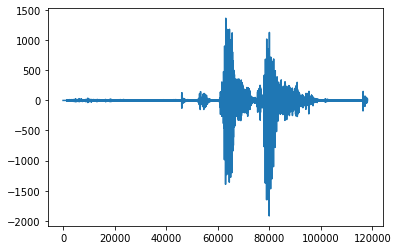

In [17]:
# Loading samples

data, rate = load_wav(path_sample)
samples = apply_endpointing(data, noise_len, window_len, p, q)

for i, s in enumerate(samples):
    play_wav(s, rate)

plt.plot(data)
plt.show()

In [18]:
# Performing DTW

templates = load_templates(path_templates)

for i, s in enumerate(samples):
    coefs = apply_coding(s, rate, coef_fun)
    matches = sorted([(t['name'], apply_dtw(coefs, get_template(t))) for t in templates], key=lambda x: x[1][0])
    print("Sample: #{}".format(i+1))
    for t, dtw in matches:
        print("{:<30}\t{:<30}\t{}".format(dtw[0], t, dtw[1]))

Sample: #1
2.5110409378151684e-07        	family-female                 	[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 1), (1, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 1), (2, 2), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2

In [ ]:
# Creating templates

templates = load_templates(path_templates)

for i, s in enumerate(samples):
    name = input("Sample #{} name: ".format(i+1))
    lpcc, mfcc = apply_coding(s, rate, 'lpcc').tolist(), apply_coding(s, rate, 'mfcc').tolist()
    templates.append({'name': name, 'lpcc': lpcc, 'mfcc': mfcc})

save_templates(path_templates, templates)